In [1]:
using Interact
using LCMGL
using StaticArrays
using CoordinateTransformations
using RigidBodyDynamics
using DataFrames, DataArrays
using Gadfly

In [2]:
import Flash
reload("Flash")

adding: /home/rdeits/locomotion/explorations/point-cloud-signed-distance/packages/v0.5/DrakeVisualizer/src/lcmtypes to the python path


In [3]:
# Construct the manipulator
arm = Flash.Models.two_link_arm(false);

# Construct the sensor and draw its view rays for debugging
sensor = Flash.DepthSensors.Kinect(41, 41);
camera_origin = SVector(0., 0, 4)
camera_tform = compose(Translation(camera_origin), LinearMap(AngleAxis(pi, 1, 0, 0)))
Flash.DepthSensors.draw_rays(sensor, camera_tform)

state = Flash.ManipulatorState(arm)
Flash.draw(state);

In [4]:
state = Flash.ManipulatorState(arm)
points = Flash.DepthSensors.raycast(state, sensor, camera_tform)
Flash.DepthSensors.draw_points(points)

In [24]:
@manipulate for x1 = linspace(-pi, pi, 101), x2 = linspace(-pi, pi, 101)
    set_configuration!(state,  [x1, x2])
    Flash.draw(state)
    points = Flash.DepthSensors.raycast(state, sensor, camera_tform)
    Flash.DepthSensors.draw_points(points)
end

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"x1",0.0,linspace(-3.141592653589793,3.141592653589793,101),".3f",true)

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"x2",0.0,linspace(-3.141592653589793,3.141592653589793,101),".3f",true)

nothing

In [9]:
# Difference between two angles, compensating for wraparound
# (taken from angleDiff.m in Drake)
function angle_diff(phi1, phi2)
    mod(phi2 - phi1 + pi, 2*pi) - pi;
end

angle_diff (generic function with 1 method)

In [10]:
# Now let's try to use the raycast data to recover the joint angles.
# We'll do that by choosing a true (hidden) robot state:
true_state = Flash.ManipulatorState(arm)
Flash.set_configuration!(true_state, [pi, 1.3])
Flash.draw(true_state)

# Now we can raycast that true state to get a set of sensed points:
sensed_points = Flash.DepthSensors.raycast(true_state, sensor, camera_tform)
Flash.DepthSensors.draw_points(sensed_points)

In [11]:
function test_gradient_descent(model, sensed_points, true_state, loops)
    x_true = copy(Flash.flatten(true_state))
    trials = Vector{DataFrame}()
    
    for i = 1:loops
        errors = Float64[]
        xs = Vector{Float64}[]
        costs = Float64[]
        
        function callback{T}(x::AbstractVector{T}, c)
            # When computing errors, we'll just ignore the last three joints, since
            # they are almost impossible to track at this scale
            x_value = Flash.value.(x)
            push!(errors, norm(angle_diff.(x_value, x_true)))
            push!(xs, x_value)
            push!(costs, Flash.value(c))
            state = Flash.ManipulatorState(model)
            Flash.GradientDescent.unflatten!(state, x_value)
            Flash.draw(state, false)
        end
        
        x_estimated = copy(x_true)
        x_estimated += 2*pi * (rand(length(x_estimated)) - 0.5)
        Flash.Tracking.estimate_state(model, sensed_points, x_estimated; callback=callback)
        push!(trials, DataFrame(x=xs, err=errors, cost=costs))
    end
    
    trials
end

test_gradient_descent (generic function with 1 method)

In [12]:
trials = test_gradient_descent(arm, sensed_points, true_state, 100);

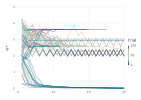

In [13]:
# Now we can plot the progress of each trial

Gadfly.plot([layer(trial, y="err", color=i+zeros(size(trial,1)), Geom.line) for (i, trial) in enumerate(trials)]..., 
    Guide.colorkey("trial"))

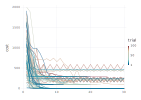

In [14]:
Gadfly.plot([layer(trial, y="cost", color=i+zeros(size(trial,1)), Geom.line) for (i, trial) in enumerate(trials)]..., 
    Guide.colorkey("trial"))

In [23]:
state = Flash.ManipulatorState(arm)
@manipulate for j = 1:length(trials), i = 1:size(trials[1], 1)
    trial = trials[j]
    set_configuration!(state.mechanism_state, trial[:x][i])
    Flash.draw(state)
    trial[:x][i], trial[:cost][i]
end

Interact.Slider{Int64}(Signal{Int64}(50, nactions=0),"j",50,1:100,"d",true)

Interact.Slider{Int64}(Signal{Int64}(10, nactions=0),"i",10,1:20,"d",true)

([4.66024,-2.62786],117.9551095472077)

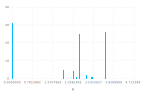

In [17]:
# A histogram of the final cost of each trial shows that most random
# configurations eventually converged to the correct answer (a final
# cost near 0.0), but that some got stuck in local minima

Gadfly.plot(x=[trial[:err][end] for trial in trials], Geom.histogram, Guide.xticks(ticks=collect(0:pi/4:3*pi/2)))

In [18]:
# Now let's repeat the trial, but starting within + or - 0.5 rad of the true
# joint angles (to simulate running online with a good initial guess).

function test_gradient_descent_close(model, sensed_points, true_state, loops)
    x_true = copy(Flash.flatten(true_state))
    trials = Vector{DataFrame}()
    
    for i = 1:loops
        errors = Float64[]
        xs = Vector{Float64}[]
        costs = Float64[]
        
        function callback{T}(x::AbstractVector{T}, c)
            # When computing errors, we'll just ignore the last three joints, since
            # they are almost impossible to track at this scale
            x_value = Flash.value.(x)
            push!(errors, norm(angle_diff.(x_value, x_true)))
            push!(xs, x_value)
            push!(costs, Flash.value(c))
            state = Flash.ManipulatorState(model)
            Flash.GradientDescent.unflatten!(state, x_value)
            Flash.draw(state, false)
        end
        
        x_estimated = copy(x_true)
        x_estimated += (rand(length(x_estimated)) - 0.5)
        Flash.Tracking.estimate_state(model, sensed_points, x_estimated; callback=callback)
        push!(trials, DataFrame(x=xs, err=errors, cost=costs))
    end
    
    trials
end

trials_close = test_gradient_descent_close(arm, sensed_points, true_state, 100);

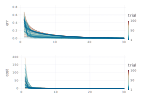

In [19]:
vstack(Gadfly.plot([layer(trial, y="err", color=i+zeros(size(trial,1)), Geom.line) for (i, trial) in enumerate(trials_close)]..., 
    Guide.colorkey("trial")),
    Gadfly.plot([layer(trial, y="cost", color=i+zeros(size(trial,1)), Geom.line) for (i, trial) in enumerate(trials_close)]..., 
    Guide.colorkey("trial")))

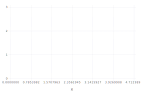

In [20]:
# When starting out reasonably close to the correct configuration, every
# single sample converged to the true joint angles. The histogram confirms:

Gadfly.plot(x=[trial[:err][end] for trial in trials_close], Geom.histogram, Guide.xticks(ticks=collect(0:pi/4:3*pi/2)))

In [22]:
@manipulate for j = 1:length(trials_close), i = 1:size(trials_close[1], 1)
    trial = trials_close[j]
    set_configuration!(state, trial[:x][i])
    Flash.draw(state)
    trial[:x][i], trial[:cost][i]
end

Interact.Slider{Int64}(Signal{Int64}(50, nactions=0),"j",50,1:100,"d",true)

Interact.Slider{Int64}(Signal{Int64}(15, nactions=0),"i",15,1:30,"d",true)

([3.12793,1.33052],0.03910830404792004)